<a href="https://colab.research.google.com/github/amgothhrithik/Search_Engine/blob/main/Retrival_from_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
embeddings = np.load("/content/drive/MyDrive/Data/search_engine/embeddings.npy")

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset =  load_dataset(
    "ashraq/fashion-product-images-small",
    split="train" )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/867 [00:00<?, ?B/s]

(…)-00000-of-00002-6cff4c59f91661c3.parquet:   0%|          | 0.00/136M [00:00<?, ?B/s]

(…)-00001-of-00002-bb459e5ac5f01e71.parquet:   0%|          | 0.00/135M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss
import numpy as np

# Convert PyTorch tensor to NumPy (FAISS works with NumPy)
embeddings_np = embeddings.astype("float32")
faiss.normalize_L2(embeddings_np)
index = faiss.IndexFlatIP(512)  # Inner Product (Cosine when normalized)
index.add(embeddings_np)

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
query_text = ["A stylish red shoes"]
text_inputs = processor(text=query_text, return_tensors="pt", padding=True).to(device)

with torch.no_grad():
    query_embedding = model.get_text_features(**text_inputs)

# Normalize for cosine similarity (since we used IndexFlatIP)
faiss.normalize_L2(query_embedding.numpy())

In [ ]:
D, I = index.search(query_embedding, 5)  # Find top 5 similar products

print("Top 5 similar product indices:", I[0])

Top 5 similar product indices: [14622    69  9585 20238 33473]


In [ ]:
import pandas as pd
df = pd.DataFrame(dataset)

In [ ]:
gender="Men"
usage=None
baseColour=None
season=None
articleType=None

In [ ]:

filtered=df.iloc[I[0]]
query = True  # Default condition (select all)

if gender is not None:
    query &= filtered["gender"] == gender  # Apply gender filter

if usage is not None:
    query &= filtered["usage"] == usage  # Apply usage filter
if baseColour is not None:
    query &= filtered["baseColour"] == baseColour

if season is not None:
    query &= filtered["season"] == season  # Apply usage filter


if articleType is not None:
    query &= filtered["articleType"] == articleType  # Apply usage filter
filtered = filtered[query]


In [ ]:
filtered

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
14622,22237,Men,Footwear,Shoes,Casual Shoes,Red,Summer,2011.0,Casual,ID Men Red Shoes,<PIL.Image.Image image mode=RGB size=60x80 at ...
69,26538,Men,Footwear,Shoes,Casual Shoes,Red,Fall,2012.0,Casual,ID Men Red Shoes,<PIL.Image.Image image mode=RGB size=60x80 at ...
9585,6363,Men,Footwear,Shoes,Casual Shoes,Red,Summer,2011.0,Casual,Numero Uno Men's Red Shoe,<PIL.Image.Image image mode=RGB size=60x80 at ...


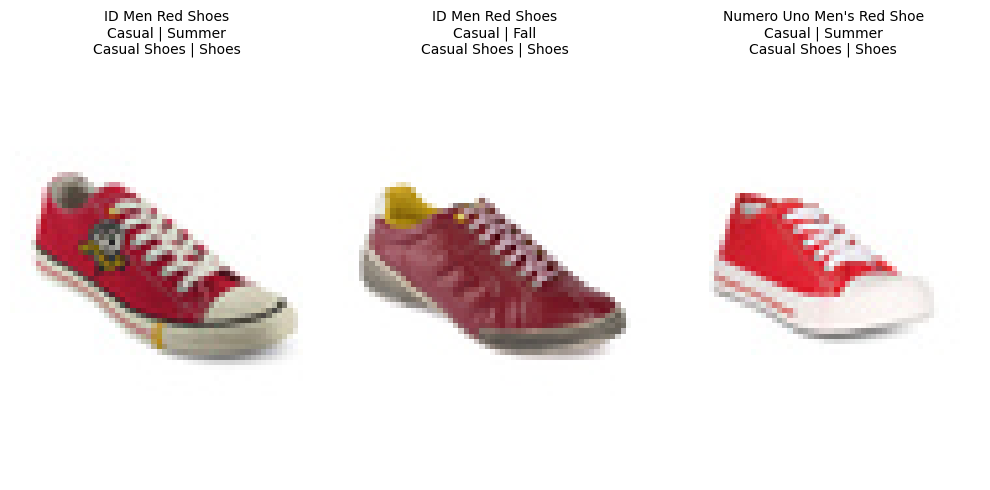

In [ ]:
import cv2
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, len(filtered), figsize=(10, 5))
for ax, (_, row) in zip(axes,filtered.iterrows()):
    img = row["image"]  # Directly use NumPy array

    ax.imshow(img)  # Display image
    ax.axis("off")  # Hide axes

    # Create text label
    label = f"{row['productDisplayName']}\n{row['usage']} | {row['season']}\n{row['articleType']} | {row['subCategory']}"
    ax.set_title(label, fontsize=10)

plt.tight_layout()
plt.show()